In [1]:
from __future__ import print_function
import os
from collections import defaultdict
from multiprocessing.pool import ThreadPool
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from more_itertools import rstrip
from sklearn import preprocessing
from scipy import stats
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('average_faces.csv')

df = df[['5_star_count',
         '4_star_count',
         '3_star_count',
         '2_star_count',
         '1_star_count',
         'average_rating',
         # 'writer_id',
         'review_count',
         'format',
         'amount_of_pages',
         'published',
         'genre_0',
         'amount_of_faces',
         'authorScore',
         'titleScore',
         'joy:',
         'sorrow',
         'anger',
         'surprise',
         'under_exposed',
         'blurred',
         'headwear',
         'face_confidence'
         ]]
#
# df = df[df['amount_of_faces'] > 0]
# df = df[['average_rating',
#          # 'writer_id',
#          # 'review_count',
#          # 'format',
#          # 'amount_of_pages',
#          # 'published',
#          # 'genre_0',
#          # 'amount_of_faces',
#          # 'authorScore',
#          # 'titleScore',
#          'joy:',
#          'sorrow',
#          'anger',
#          'surprise',
#          'under_exposed',
#          'blurred',
#          'headwear',
#          'face_confidence'
#          ]]



le = preprocessing.LabelEncoder()
df['format'] = le.fit_transform(df['format'])
df['genre_0'] = le.fit_transform(df['genre_0'])
df = df.replace('1 page', '1')

df = df.astype(float)
df = df.dropna()
# df = df[df["5_star_count"] != -1]
df = df.replace(-1, 0)

# fig = plt.figure(figsize = (5,25))
# ax = fig.gca()
# df.plot.hist(bins=1000, subplots=True, ax=ax)

transformations = []
for col in df.columns:
    before = df[col].skew()
    log1p = np.log1p(df[col]).skew()
    sqrt = np.sqrt(df[col]).skew()
    # stats = stats.boxcox(df[col])[0]
    abs_log1p = abs(log1p)
    abs_sqrt = abs(sqrt)
    if abs_sqrt < abs_log1p:
        transformations.append({"transformation": "sqrt", "column": col, "skew": abs_sqrt})
        df[col] = np.sqrt(df[col])
    else:
        transformations.append({"transformation": "log1p", "column": col, "skew": abs_log1p})
        df[col] = np.log1p(df[col])

[print(x) for x in transformations]

# fig = plt.figure(figsize = (5,25))
# ax = fig.gca()
# df.plot.hist(bins=1000, subplots=True, ax=ax)####### SGD


{'transformation': 'log1p', 'column': '5_star_count', 'skew': 0.08210359315529273}
{'transformation': 'log1p', 'column': '4_star_count', 'skew': 0.04572263729910392}
{'transformation': 'log1p', 'column': '3_star_count', 'skew': 0.12683655663473872}
{'transformation': 'log1p', 'column': '2_star_count', 'skew': 0.37112661959682886}
{'transformation': 'log1p', 'column': '1_star_count', 'skew': 0.6314333127350469}
{'transformation': 'sqrt', 'column': 'average_rating', 'skew': 1.3217969913497916}
{'transformation': 'log1p', 'column': 'review_count', 'skew': 0.11133510781646143}
{'transformation': 'sqrt', 'column': 'format', 'skew': 2.9465446340498502}
{'transformation': 'sqrt', 'column': 'amount_of_pages', 'skew': 0.7717310484791366}
{'transformation': 'sqrt', 'column': 'published', 'skew': 34.42878770318031}
{'transformation': 'sqrt', 'column': 'genre_0', 'skew': 0.7645500257306163}
{'transformation': 'sqrt', 'column': 'amount_of_faces', 'skew': 2.5115274180004046}
{'transformation': 'log1

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [2]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# df.reset_index(inplace=True)
X = df.loc[:, df.columns != 'average_rating']
y = df['average_rating']
y = y.round(decimals=0)

# Split the data into two parts with 1000 points in the test data
# This creates a generator
strat_shuff_split = StratifiedShuffleSplit(n_splits=1, test_size=0.33,  random_state=42)
df.reset_index(inplace=True, drop=True)
# df = df.loc[:, df.columns != 'index']
# Get the index values from the generator
train_idx, test_idx = next(strat_shuff_split.split(X, y))
# Create the data sets
X_train = df.loc[train_idx, X.columns]
y_train = df.loc[train_idx, 'average_rating']

X_test = df.loc[test_idx, X.columns]
y_test = df.loc[test_idx, 'average_rating']

param_grid = {
    'sgdregressor__tol': [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8],
    'sgdregressor__max_iter': [1, 10, 100, 1000, 10000],
    'sgdregressor__alpha': 10.0**-np.arange(1,10),
    'sgdregressor__penalty': ['l2', 'l1', 'elasticnet'],

}
pipe = make_pipeline(StandardScaler(),
                    SGDRegressor())
gs = GridSearchCV(pipe, param_grid, n_jobs=-1, verbose=True, return_train_score=True)
gs.fit(X_train, y_train)
print(gs.score(X_test, y_test))
swag = pd.DataFrame(gs.cv_results_)
print(gs.best_params_)

Fitting 5 folds for each of 810 candidates, totalling 4050 fits
0.6351863221156671
{'sgdregressor__alpha': 1e-05, 'sgdregressor__max_iter': 10000, 'sgdregressor__penalty': 'l1', 'sgdregressor__tol': 1e-08}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 536 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 1410 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 2096 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done 2996 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 4050 out of 4050 | elapsed:  1.5min finished


Correlation between pred and act: 0.9196189019476196
Amount of values after removing outliers: 5041


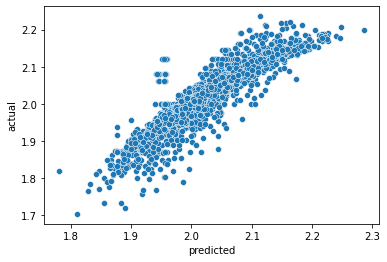

In [3]:
from sklearn.metrics import confusion_matrix

estimator = gs.best_estimator_

y_pred = estimator.predict(X_test)

detect_outliers = pd.DataFrame(data={'pred':y_pred, 'act':y_test})
detect_outliers.reset_index(inplace=True, drop=True)
detect_outliers['diff'] = (detect_outliers['pred'] - detect_outliers['act']).abs()
detect_outliers = detect_outliers[detect_outliers['diff'] < 0.2]
print(f"Correlation between pred and act: {detect_outliers[['act', 'pred']].corr().iloc[0,1]}")
print(f"Amount of values after removing outliers: {len(detect_outliers)}")
plt.xlabel("predicted")
plt.ylabel("actual")
p = sns.scatterplot(x=detect_outliers['pred'], y=detect_outliers['act'])
plt.savefig('../imgs/predictions_without_stars.svg')

# sns.set_context('talk')
# cm = confusion_matrix(y_test, y_pred)
# ax = sns.heatmap(cm, annot=True, fmt='d')